In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ReadCameraModel import ReadCameraModel
from UndistortImage import UndistortImage

# Preprocessing
* Computing instrinic camera parameters
* Demosaic and transform all images

In [4]:
data_path = "./Oxford_dataset_reduced/images"
model_path = "./Oxford_dataset_reduced/model"

In [5]:
fx, fy, cx, cy, _, LUT = ReadCameraModel(model_path)
K = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1],
])

In [6]:
file_list = sorted([file for file in os.listdir(data_path) if file.endswith(".png")])
filename = file_list[0]
file_path = os.path.join(data_path, filename)
print(file_path)

./Oxford_dataset_reduced/images\1399381446267196.png


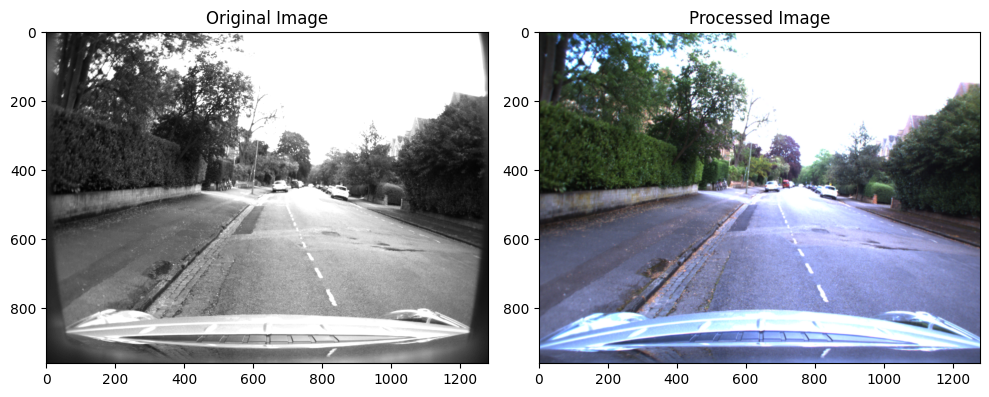

In [7]:
image = cv2.imread(file_path, flags=-1)
processed_image = cv2.cvtColor(image, cv2.COLOR_BayerGR2BGR)
processed_image = UndistortImage(processed_image, LUT)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB), cmap="gray")
plt.title("Processed Image")
plt.tight_layout()
plt.show()


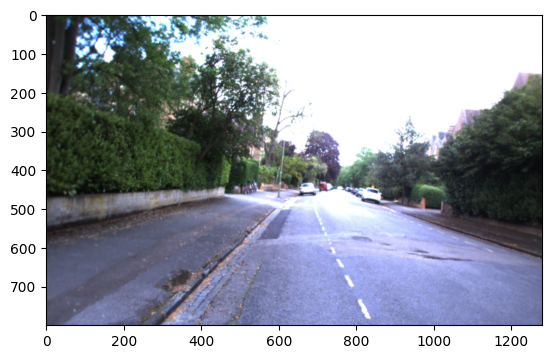

In [8]:
crop = processed_image[:800, :]
plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB), cmap="gray")

Run `preprocessor.py`

# Keypoint Matching

Keypoints detected using SIFT feature detector, matches found via brute force KNN match.
Run `keypt_matching.py`

In [9]:
import json

In [10]:
def load_images(path):
    images = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        if img is not None:
            images.append(img)
    return images

In [11]:
data_path = "./preprocessed-data/images"
correspondences_path = "point_correspondences.json"

In [12]:
# Load the point correspondences from the JSON file
with open(correspondences_path, "r") as f:
    point_correspondences = json.load(f)

# Load the images
images = load_images(data_path)

# Specify the frame index for which you want to display the correspondences
frame_index = 0

# Extract the point correspondences for the specified frame
correspondences = point_correspondences[frame_index]

# Create keypoints from the point correspondences
keypoints1 = [cv2.KeyPoint(x=p[0][0], y=p[0][1], size=1) for p in correspondences]
keypoints2 = [cv2.KeyPoint(x=p[1][0], y=p[1][1], size=1) for p in correspondences]

# Create matches from the point correspondences
matches = [cv2.DMatch(idx, idx, 0) for idx in range(len(correspondences))]
print(len(matches))



1418


In [13]:
import random
matches = random.sample(matches, 30)

In [14]:
# params for cv2.drawMatches
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=None,
                   matchesMask=None,
                   flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
                   matchesThickness=2)


# Draw the matches between the two frames
img_matches = cv2.drawMatches(
    images[frame_index], keypoints1, images[frame_index + 1], keypoints2, matches, None, **draw_params
)

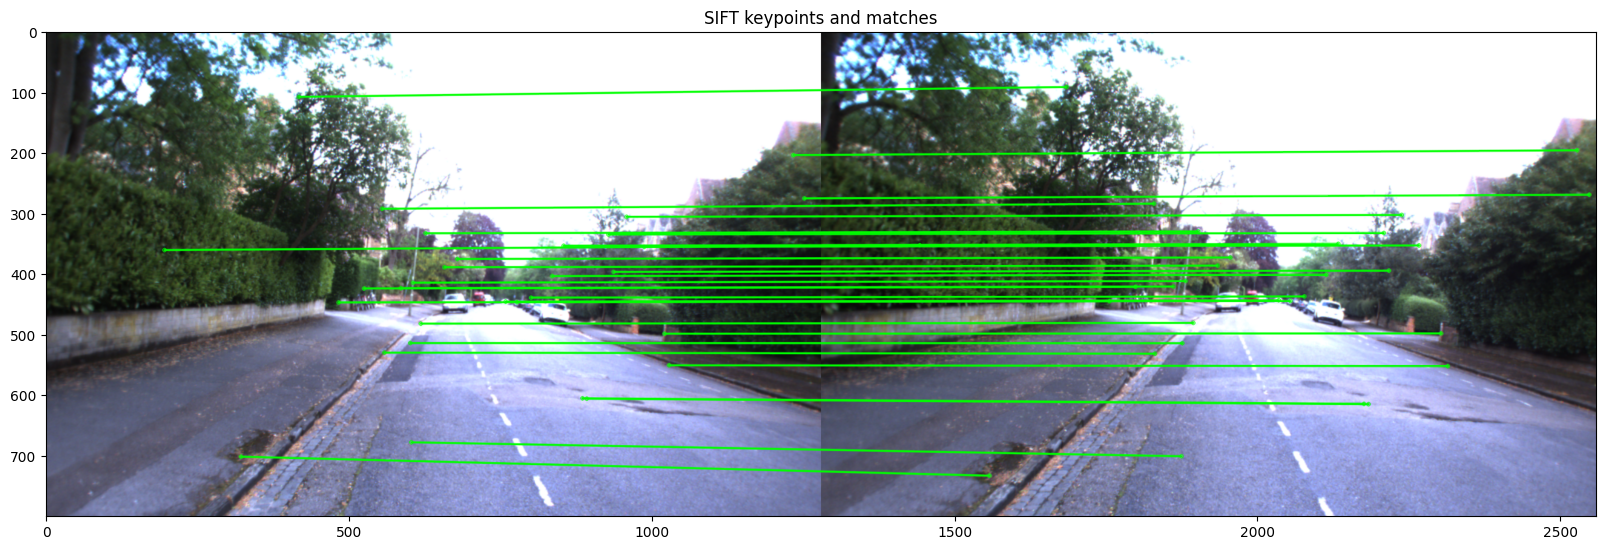

In [15]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("SIFT keypoints and matches")
plt.show()


# Estimating F and E
Use `cv2.findFundamentalMat()` and manually compute E

In [2]:
import json
with open("point_correspondences.json", "r") as f:
    point_correspondences = json.load(f)

K = np.load("./preprocessed-data/model/K.npy")

In [3]:
i = 0
pts1 = np.array(point_correspondences[i])[:,0]
pts2 = np.array(point_correspondences[i])[:,1]

print(pts1.shape, pts2.shape)

(1418, 2) (1418, 2)


In [4]:
print(pts1[:5, :])

[[ 71.99211884 440.53723145]
 [ 73.04669952 455.91012573]
 [ 75.42459869 296.65808105]
 [ 76.59870148 383.24517822]
 [ 78.30621338 448.81451416]]


In [5]:
print(pts2[:5, :])

[[ 20.62677002 438.17269897]
 [ 22.57045174 454.62356567]
 [ 23.54984856 281.93591309]
 [ 25.56627846 375.70681763]
 [ 28.05304337 446.60998535]]


In [6]:
F, _ = cv2.findFundamentalMat(pts1,
                                pts2,
                                cv2.FM_7POINT,
                                ransacReprojThreshold=0.5,
                                confidence=0.99)
E = K.T @ F @ K
U, _, VT = np.linalg.svd(E)
S = np.array([[1, 0, 0],
                [0, 1, 0],
                [0, 0, 0]])
E = U @ S @ VT

In [7]:
print(F)

[[ 1.58431920e-06  8.30404416e-04 -3.56984806e-01]
 [-8.30378185e-04  1.86466111e-06  5.29472210e-01]
 [ 3.52913868e-01 -5.28063808e-01  1.00000000e+00]]


In [8]:
_, R, T, _ = cv2.recoverPose(E, pts1, pts2, K)

In [9]:
np.linalg.det(R)

1.0000000000000002

In [10]:
transform = np.eye(4)
transform[:3, :3] = R
transform[:3, 3] = T.flatten()
print(transform)

[[ 0.99999052 -0.00197663 -0.00388101  0.00913849]
 [ 0.00196683  0.99999487 -0.00252776  0.06020213]
 [ 0.00388598  0.00252011  0.99998927 -0.99814437]
 [ 0.          0.          0.          1.        ]]


In [11]:
new_pose = np.column_stack((R, T))
new_pose = np.vstack((new_pose, np.array([0,0,0,1])))
print(new_pose)

[[ 0.99999052 -0.00197663 -0.00388101  0.00913849]
 [ 0.00196683  0.99999487 -0.00252776  0.06020213]
 [ 0.00388598  0.00252011  0.99998927 -0.99814437]
 [ 0.          0.          0.          1.        ]]


# Custom F Matrix

In [12]:
def normalize(x, y):
    """
    Function: find the transformation T to make coordinates zero mean and the variance as sqrt(2)
    Input: x, y - coordinates
    Output: normalized coordinates, transformation T
    """
    # YOUR CODE HERE:
    # Zero-mean the coordinates
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_norm = x - x_mean
    y_norm = y - y_mean

    # Compute the average distance to center
    d = np.mean(np.sqrt(x_norm**2 + y_norm**2))

    # Scale the coordinates using distance
    s = np.sqrt(2) / d
    x_norm = x_norm * s
    y_norm = y_norm * s

    # Construct T
    T = np.array([[s, 0, -x_mean * s], [0, s, -y_mean * s], [0, 0, 1]])

    return np.concatenate((x_norm, y_norm), axis=1), T


def ransacF(x1, y1, x2, y2, n=7, num_iterations=1000, threshold=0.1):
    """
    Find normalization matrix
    Transform point set 1 and 2
    RANSAC based 8-point algorithm
    Input:
        x1, y1, x2, y2 - coordinates
        num_iterations - how many iterations
        threshold - threshold for inlier check
    Output:
        Best fundamental matrix
        corresponding inlier indices
    """
    # YOUR CODE HERE:

    max_inliers = 0
    best_F = None
    best_inliers = None

    # Hint:
    # for ... in num_iterations:
    for i in range(num_iterations):
    #    1. Randomly select n points
        indices = np.random.choice(x1.shape[0], n, replace=False)
        select_x1 = x1[indices]
        select_y1 = y1[indices]
        select_x2 = x2[indices]
        select_y2 = y2[indices]

    #    2. Call computeF()
        F = computeF(select_x1, select_y1, select_x2, select_y2)

    #    3. Call getInliers()
        curr_inliers = getInliers(x1, y1, x2, y2, F, threshold)

    #    4. Update F and inliers.
        if len(curr_inliers) > max_inliers:
            max_inliers = len(curr_inliers)
            best_F = F
            best_inliers = curr_inliers

    return best_F, best_inliers


def computeF(x1, y1, x2, y2):
    """
    Function: compute fundamental matrix from corresponding points
    Input:
        x1, y1, x2, y2 - coordinates
    Output:
        fundamental matrix, 3x3
    """
    # YOUR CODE HERE:

    # Hint:
    # 1. Make matrix A
    n = x1.shape[0]
    A = np.zeros((n, 9))
    print(A.shape)

    A[:, 0] = x1 * x2
    A[:, 1] = x1 * y2
    A[:, 2] = x1
    A[:, 3] = y1 * x2
    A[:, 4] = y1 * y2
    A[:, 5] = y1
    A[:, 6] = x2
    A[:, 7] = y2
    A[:, 8] = 1

    # 2. Do SVD for A
    U, S, VT = np.linalg.svd(A)
    
    print("A", A)
    print(A.shape)
    print("A rank", np.linalg.matrix_rank(A))

    # 3. Find fundamental matrix F
    f = VT.T[:, -1]
    print(f)
    F = f.reshape(3, 3).T

    # 4. Resolve det(F)=0
    U, S, VT = np.linalg.svd(F)
    S[-1] = 0
    F = np.dot(U, np.dot(np.diag(S), VT))

    return F


def getInliers(x1, y1, x2, y2, F, thresh):
    """
    Function: implement the criteria checking inliers.
    Input:
        x1, y1, x2, y2 - coordinates
        F - estimated fundamental matrix, 3x3
        thresh - threshold for passing the error
    Output:
        inlier indices
    """
    # YOUR CODE HERE:

    # Hints:
    # Say we project the points onto the second image
    # 1. Compute epipolar lines. Here a line is expressed as a vector
    # Recall line equation: ax + by + c = 0
    lines = np.dot(F, np.vstack((x2, y2, np.ones_like(x2))))
    a, b, c = lines[0], lines[1], lines[2]

    # 2. Calculate the distances of points in the second image from the corresponding lines
    # Recall that the distance between a point and a line is
    # d = |ax + by + c| / sqrt(a^2 + b^2)
    distances = np.abs(a*x1 + b*y1 + c) / np.sqrt(a**2 + b**2)

    # 3. Check distances with the threshold and find inliers
    inliers = distances < thresh

    return np.where(inliers)[0]


In [13]:
# No rush, let's do a sanity check for computeF()
from sklearn.metrics import mean_squared_error

# A synthetic dataset with matched points
p1 = np.array([[83, 245], [39, 461], [284, 243],[328, 459],   # points of image1 in 2D coordinates
              [331, 166], [286, 47], [291, 332],[296, 303]])
p2 = np.array([[36, 155], [34, 625], [329, 158],[323, 627],   # points of image2 in 2D coordinates
              [375, 714], [375, 67], [313, 398],[327, 331]])

px1, py1 = p1[:, :1], p1[:, 1:2]
px2, py2 = p2[:, :1], p2[:, 1:2]

# Normalize points
norm_p1, T1 = normalize(px1, py1)
norm_x1, norm_y1 = norm_p1[:, :1].flatten(), norm_p1[:, 1:2].flatten()
norm_p2, T2 = normalize(px2, py2)
norm_x2, norm_y2 = norm_p2[:, :1].flatten(), norm_p2[:, 1:2].flatten()

# Compute fundamental matrix with computeF()
F_ours = computeF(norm_x1, norm_y1, norm_x2, norm_y2)
F_ours = np.matmul(np.matmul(np.transpose(T2),F_ours), T1)
F_ours = F_ours / F_ours[2, 2]
print("Our F: ", F_ours)
# Compute fundamental matrix with cv2.findFundamentalMat()
F_cv2, _ = cv2.findFundamentalMat(p1, p2, method=cv2.FM_8POINT)
print("CV2 F: ", F_cv2)

# Display difference, expected to be very small.
mse_err = mean_squared_error(F_ours, F_cv2)
print(f'\n MSE of fundamental matrixes = {mse_err }')

if mse_err < 1e-12:
    print("Sanity check passed!")
else:
    print("Sanify check failed!")

(8, 9)
A [[ 1.97577432  1.98768962 -1.50046082  0.45904961  0.461818   -0.3486157
  -1.31677835 -1.32471945  1.        ]
 [ 2.54379107 -2.66130316 -1.91503084 -2.24028832  2.3437799   1.68654623
  -1.32832904  1.38969206  1.        ]
 [ 0.14767021 -0.51428989  0.39337042 -0.13794343  0.48041451 -0.36745979
   0.37539734 -1.30739342  1.        ]
 [ 0.27530189  1.13212068  0.80794044  0.56826162  2.33685552  1.66770213
   0.34074527  1.40124275  1.        ]
 [ 0.53606122  1.59188449  0.83620658 -0.70065466 -2.0806603  -1.09295733
   0.64106314  1.90369765  1.        ]
 [ 0.26425553 -0.75556846  0.41221451 -1.4194297   4.058482   -2.2141808
   0.64106314 -1.83294969  1.        ]
 [ 0.12998515  0.03614383  0.45932474  0.13331811  0.0370706   0.4711023
   0.28299184  0.07868906  1.        ]
 [ 0.18426467 -0.15611312  0.50643497  0.07199178 -0.06099303  0.19786297
   0.36384665 -0.30825897  1.        ]]
(8, 9)
A rank 8
[ 0.00242421  0.02960508 -0.61959211  0.10179495  0.00569418  0.03301519


In [14]:
x1, y1 = pts1[:, 0:1], pts1[:, 1:2]
x2, y2 = pts2[:, 0:1], pts2[:, 1:2]
print(x1.shape)

(1418, 1)


In [15]:
norm_p1, T1 = normalize(x1, y1)
norm_x1, norm_y1 = norm_p1[:, :1].flatten(), norm_p1[:, 1:2].flatten()
norm_p2, T2 = normalize(x2, y2)
norm_x2, norm_y2 = norm_p2[:, :1].flatten(), norm_p2[:, 1:2].flatten()

print(norm_x1.shape)


(1418,)


In [16]:
p = 0.99
e = 0.5
s = 8
num_iter = int(np.log(1 - p) / np.log(1 - (1 - e)**s))
F_norm, inliers = ransacF(norm_x1, norm_y1, norm_x2, norm_y2, num_iterations=num_iter)

F = T2.T @ F_norm @ T1

F = F / F[2, 2]

print(F)
"""
[[ 1.58431920e-06  8.30404416e-04 -3.56984806e-01]
 [-8.30378185e-04  1.86466111e-06  5.29472210e-01]
 [ 3.52913868e-01 -5.28063808e-01  1.00000000e+00]]
"""

(7, 9)
A [[ 4.21586523e-02 -3.47867812e-01 -2.04562668e-01 -3.31316471e-01
   2.73382400e+00  1.60761736e+00 -2.06091623e-01  1.70054397e+00
   1.00000000e+00]
 [ 1.54585217e+00 -2.10512949e+00 -1.20780592e+00 -2.10907417e+00
   2.87212084e+00  1.64786279e+00 -1.27988458e+00  1.74293689e+00
   1.00000000e+00]
 [-1.85212376e-04  1.28455969e-02 -1.57299389e-02 -9.68977041e-03
   6.72044102e-01 -8.22944451e-01  1.17745133e-02 -8.16633616e-01
   1.00000000e+00]
 [ 1.46696602e+00 -1.87641040e-01 -1.23293411e+00 -2.09551842e-01
   2.68039783e-02  1.76121062e-01 -1.18981705e+00  1.52190647e-01
   1.00000000e+00]
 [ 2.54191871e+00 -8.19968052e-01  1.60737031e+00 -8.07271402e-01
   2.60408311e-01 -5.10474263e-01  1.58141450e+00 -5.10130147e-01
   1.00000000e+00]
 [ 4.27019925e+00  1.45889556e-01 -2.06784452e+00  1.01321820e-01
   3.46161722e-03 -4.90651039e-02 -2.06504851e+00 -7.05515111e-02
   1.00000000e+00]
 [ 1.27715732e+00 -1.36526701e+00 -1.11466231e+00 -1.36821719e+00
   1.46260900e+00  

'\n[[ 1.58431920e-06  8.30404416e-04 -3.56984806e-01]\n [-8.30378185e-04  1.86466111e-06  5.29472210e-01]\n [ 3.52913868e-01 -5.28063808e-01  1.00000000e+00]]\n'

# Estimate Pose

## Linear Triagulation

In [17]:
from estimate_pose import recoverPoseCustom

In [18]:
F, K

(array([[ 7.09620803e-07,  1.07671916e-03, -4.74975885e-01],
        [-1.07499892e-03,  4.02753992e-06,  6.73400645e-01],
        [ 4.71246573e-01, -6.73845601e-01,  1.00000000e+00]]),
 array([[964.828979,   0.      , 643.788025],
        [  0.      , 964.828979, 484.40799 ],
        [  0.      ,   0.      ,   1.      ]]))

In [19]:
def estimate_E(F, K):
    E = K.T @ F @ K
    U, _, VT = np.linalg.svd(E)
    S = np.array([[1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 0]])
    E = U @ S @ VT
    return E

E = estimate_E(F, K)
E

array([[ 2.31407624e-03,  9.98766424e-01,  4.52638098e-02],
       [-9.98751014e-01,  2.08792049e-03, -1.61750589e-02],
       [-4.71837734e-02,  2.03850951e-02,  1.54456006e-04]])

In [20]:
_, R_base, T_base, _ = cv2.recoverPose(E, pts1, pts2, K)

In [37]:
def extract_poses(E):
    """
    Function: extract the rotation and translation from the essential matrix.
    Input: E - essential matrix, 3x3
    Output: All possible rotation and translation pairs.
    """
    U, _, Vt = np.linalg.svd(E)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

    C1 = U[:, 2]
    R1 = U @ W @ Vt
    C2 = -U[:, 2]
    R2 = U @ W @ Vt
    C3 = U[:, 2]
    R3 = U @ W.T @ Vt
    C4 = -U[:, 2]
    R4 = U @ W.T @ Vt

    poses = [(C1, R1), (C2, R2), (C3, R3), (C4, R4)]
    return poses

def linear_triangulation(P1, P2, pts1, pts2):
    """
    Function: linear triangulation method.
    Input:
        P1, P2 - projection matrices, 3x4
        pts1, pts2 - corresponding points, Nx2
    Output: 3D points, Nx3
    """
    N = pts1.shape[0]
    pts3D = np.zeros((N, 3))

    for i in range(N):
        x1, y1 = pts1[i]
        x2, y2 = pts2[i]

        A = np.array([
            x1 * P1[2] - P1[0],
            y1 * P1[2] - P1[1],
            x2 * P2[2] - P2[0],
            y2 * P2[2] - P2[1]
        ])

        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1, :4]
        X = X / X[3]
        pts3D[i] = X[:3]

    return pts3D

def check_cheirality(C, R, X):
    """
    Function: check the cheirality condition for a given pose.
    Input:
        C - camera center, 3x1
        R - rotation matrix, 3x3
        pts3D - 3D points, Nx3
    Output: number of points satisfying the cheirality condition
    """
    N = X.shape[0]
    count = 0

    for i in range(N):
        X_i = X[i]
        if np.dot(R[2], (X_i - C) / np.linalg.norm(X_i - C)) > 0 and X_i[2] > 0:
            count += 1

    return count



In [38]:
poses = extract_poses(E)
best_count = 0
best_pose = None

for C, R in poses:
    if np.linalg.det(R) < 0:
        C = -C
        R = -R

    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = K @ np.hstack((R, -R @ C.reshape(3, 1)))
    X_linear = linear_triangulation(P1, P2, pts1, pts2)
    
    print(C.shape, R.shape, X_linear.shape)
    count = check_cheirality(C, R, X_linear)
    if count > best_count:
        best_count = count
        best_pose = (C, R)

if best_pose is None:
    raise ValueError("No pose found satisfying the cheirality condition.")

C, R = best_pose
T = -R @ C.reshape(3, 1)

(3,) (3, 3) (1418, 3)
(3,) (3, 3) (1418, 3)
(3,) (3, 3) (1418, 3)
(3,) (3, 3) (1418, 3)


In [39]:
print(R)
print(T)
print("--------------------")
print(R_base)
print(T_base)

[[ 0.99998927 -0.00213043 -0.00411473]
 [ 0.00212236  0.99999582 -0.00196563]
 [ 0.0041189   0.00195687  0.9999896 ]]
[[ 0.02429303]
 [ 0.04923322]
 [-0.99849183]]
--------------------
[[ 0.99998927 -0.00213043 -0.00411473]
 [ 0.00212236  0.99999582 -0.00196563]
 [ 0.0041189   0.00195687  0.9999896 ]]
[[ 0.02028457]
 [ 0.04722733]
 [-0.99867818]]


In [40]:
from scipy.optimize import least_squares

def reproj_error(X, P, pts):
    n = pts.shape[0]
    X_hom = np.hstack((X.reshape(n, 3), np.ones((n, 1))))
    
    pts_proj = P @ X_hom.T
    pts_proj = pts_proj / pts_proj[2]

    error = np.sum((pts - pts_proj[:2].T)**2, axis=1)        
    return error

def non_linear_triangulation(P1, P2, pts1, pts2, X):
    def error(X, P1, P2, pts1, pts2):
        return reproj_error(X, P1, pts1)+reproj_error(X, P2, pts2)
    
    X_refined = least_squares(error, X.flatten(), args=(P1, P2, pts1, pts2),
                       ftol=1e-5, xtol=1e-5, gtol=1e-5, max_nfev=50, verbose=2).x
    return X_refined.reshape(-1, 3)    

In [28]:
from scipy.spatial.transform import Rotation

def nonlinear_pnp(X, pts, K, C_init, R_init):
    def error(params, X, pts, K):
        C = params[:3].reshape(3, 1)
        q = params[3:]
        R = Rotation.from_quat(q).as_matrix()
        P = K @ np.hstack((R, -R @ C))
        return reproj_error(X, P, pts)

    init_params = np.hstack((C_init.flatten(), Rotation.from_matrix(R_init).as_quat()))
    result = least_squares(error, init_params, args=(X, pts, K), ftol=1e-6, xtol=1e-6, gtol=1e-6, max_nfev=100, verbose=2)
    
    C_refined = result.x[:3].reshape(3, 1)
    q_refined = result.x[3:]
    R_refined = Rotation.from_quat(q_refined).as_matrix()
    
    return C_refined, R_refined


In [29]:
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = K @ np.hstack((R, -R @ C.reshape(3, 1)))
X = linear_triangulation(P1, P2, pts1, pts2)
X_refined = non_linear_triangulation(P1, P2, pts1, pts2, X)

C_refined, R_refined = nonlinear_pnp(X_refined, pts2, K, C, R)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.9570e+09                                    2.22e+11    
       1              6         4.0916e+09      5.87e+09       7.85e-02       3.53e+10    
       2              8         3.3437e+09      7.48e+08       1.96e-02       1.54e+10    
       3              9         3.2782e+09      6.55e+07       3.93e-02       2.02e+10    
       4             10         3.1072e+09      1.71e+08       9.81e-03       1.01e+10    
       5             11         3.0405e+09      6.67e+07       1.96e-02       7.55e+09    
       6             12         3.0066e+09      3.39e+07       1.96e-02       9.81e+09    
       7             13         2.9610e+09      4.56e+07       4.91e-03       5.15e+09    
       8             14         2.9227e+09      3.83e+07       9.81e-03       4.44e+09    
       9             15         2.8885e+09      3.42e+07       9.81e-03       3.77e+09    

In [30]:
C_refined, R_refined

(array([[ 0.01612793],
        [ 0.03506193],
        [-1.00070917]]),
 array([[-0.99945206,  0.0058851 , -0.03257217],
        [-0.00399606, -0.99832252, -0.05775968],
        [-0.03285745, -0.05759787,  0.99779901]]))

In [31]:
np.linalg.det(R_refined)

1.0000000000000007

In [33]:
def check_cheirality(C, R, X):
    """
    Function: check the cheirality condition for a given pose.
    Input:
        C - camera center, 3x1
        R - rotation matrix, 3x3
        pts3D - 3D points, Nx3
    Output: number of points satisfying the cheirality condition
    """
    N = X.shape[0]
    count = 0

    for i in range(N):
        X_i = X[i]
        if np.dot(R[2], (X_i - C) / np.linalg.norm(X_i - C)) > 0 and X_i[2] > 0:
            count += 1

    return count

In [42]:
print(C_refined.flatten().shape, R_refined.shape, X_refined.shape)
check_cheirality(C_refined.flatten(), R_refined, X)

(3,) (3, 3) (1418, 3)


0